In [1]:
# %load_ext lab_black


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as myFunc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)

# Cleaning of rejected_loan_df

In [4]:
rejected_loan_df = pd.read_csv("rejected_2007_to_2018Q4.csv")

Our dataset of rejected loans have more then 27 millions rows and 9 columns.  So we may see, that just 2 out of 27 millions gets accepted the loan.

In [5]:
rejected_loan_df.sample(5)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
1841253,6000.00,2018-08-10,Home buying,NaN,17.13%,985xx,WA,< 1 year,0.00
3728007,5000.00,2018-03-14,Moving and relocation,NaN,0.95%,082xx,NJ,< 1 year,0.00
7473685,20000.00,2015-04-21,other,NaN,30%,206xx,MD,< 1 year,0.00
4997479,10000.00,2018-10-11,Business,NaN,0.96%,883xx,NM,9 years,0.00
970403,15000.00,2016-09-22,Other,502.00,8.35%,112xx,NY,< 1 year,0.00


- Checking for duplicates

In [6]:
rejected_loan_df.duplicated().sum()

18518

We have duplicated lines. In modeling part we will need to drop it.

## Missing values

At this point i will not drop or impute any missing values. Later in modeling part I will impute it with -9999.

In [7]:
rejected_loan_df.isnull().sum()

Amount Requested              0
Application Date              0
Loan Title                  404
Risk_Score              6166697
Debt-To-Income Ratio          0
Zip Code                     96
State                         9
Employment Length        318195
Policy Code                 291
dtype: int64

## Data transormation

Let's seperate moth and year from string value of Application Date.

In [8]:
rejected_loan_df["Month"] = rejected_loan_df["Application Date"].str[5:7].astype(int)
rejected_loan_df["Year"] = rejected_loan_df["Application Date"].str[:4].astype(int)

Let's drop features, wich we will not be using.

In [9]:
rejected_loan_df = rejected_loan_df.drop(
    ["Application Date", "Zip Code", "Loan Title"], axis=1
)

Let's remove percentage symbol from Debt-To-Income Ratio.

In [10]:
rejected_loan_df["Debt-To-Income Ratio"] = (
    rejected_loan_df["Debt-To-Income Ratio"].str.replace("%", "").astype(float)
)

Also we need to transform string to numeric in Employment Length.

In [11]:
rejected_loan_df["Employment Length"] = (
    rejected_loan_df["Employment Length"]
    .replace(
        {
            "< 1 year": "0",
            "1 year": "1",
            "2 years": "2",
            "3 years": "3",
            "4 years": "4",
            "5 years": "5",
            "6 years": "6",
            "7 years": "7",
            "8 years": "8",
            "9 years": "9",
            "10+ years": "10",
        }
    )
    .astype(float)
)

In [12]:
rejected_loan_df.sample(5)

,Amount Requested,Risk_Score,Debt-To-Income Ratio,State,Employment Length,Policy Code,Month,Year
125240,10000.00,732.00,24.24,CA,7.00,0.00,11,2011
1680770,8000.00,NaN,22.01,OH,0.00,0.00,7,2018
640563,10000.00,NaN,0.00,SC,0.00,0.00,7,2016
3923213,40000.00,NaN,13.50,TX,NaN,0.00,7,2017
1633154,5000.00,NaN,16.26,SC,0.00,0.00,7,2018


We managed to transform most of the features to numerics features.

# Categorical data check

In [13]:
object_cols = rejected_loan_df.select_dtypes(include=object)
object_cols.head()

,State
0,MD
1,NY
2,CO
3,KY
4,AL


We have just only one categorical feature from rejected dataset.

In [14]:
myFunc.count_unique_values(object_cols).sort_values(
    by="Unique Value Count", ascending=False
)


,Column name,Unique Value Count
0,State,51


We may see, that it has around 50 different possible values. Let's check if all values looks correct.

In [15]:
col_lst = object_cols.columns.to_list()

for col in col_lst:
    print(object_cols[col].unique())

['MD' 'NY' 'CO' 'KY' 'AL' 'TX' 'OH' 'MN' 'CT' 'CA' 'IN' 'GA' 'MA' 'FL'
 'PA' 'KS' 'WV' 'TN' 'UT' 'WA' 'NC' 'VA' 'VT' 'MS' 'MO' 'SC' 'WI' 'AK'
 'MI' 'AR' 'NM' 'IL' 'HI' 'NJ' 'NE' 'LA' 'OK' 'DC' 'AZ' 'DE' 'ME' 'NV'
 'ID' 'NH' 'WY' 'OR' 'MT' 'RI' 'IA' 'ND' 'SD' nan]


Categorical features looks good. Let's check numerics.

### Numeric Features check

#### Outliers

In [16]:
rejected_loan_df.describe()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Policy Code,Month,Year
count,9216247.00,3049550.00,9216247.00,8898052.00,9215956.00,9216247.00,9216247.00
mean,13138.79,628.12,141.84,0.71,0.01,6.95,2016.48
std,15032.03,90.07,4474.53,1.97,0.11,3.37,1.66
min,0.00,0.00,-1.00,0.00,0.00,1.00,2007.00
25%,4925.00,591.00,8.07,0.00,0.00,4.00,2016.00
50%,10000.00,637.00,19.99,0.00,0.00,7.00,2017.00
75%,20000.00,675.00,36.62,0.00,0.00,10.00,2018.00
max,1400000.00,990.00,7374826.00,10.00,2.00,12.00,2018.00


We may see, that Debt-To-Income Ratio has very strange values. It should be a percentage.

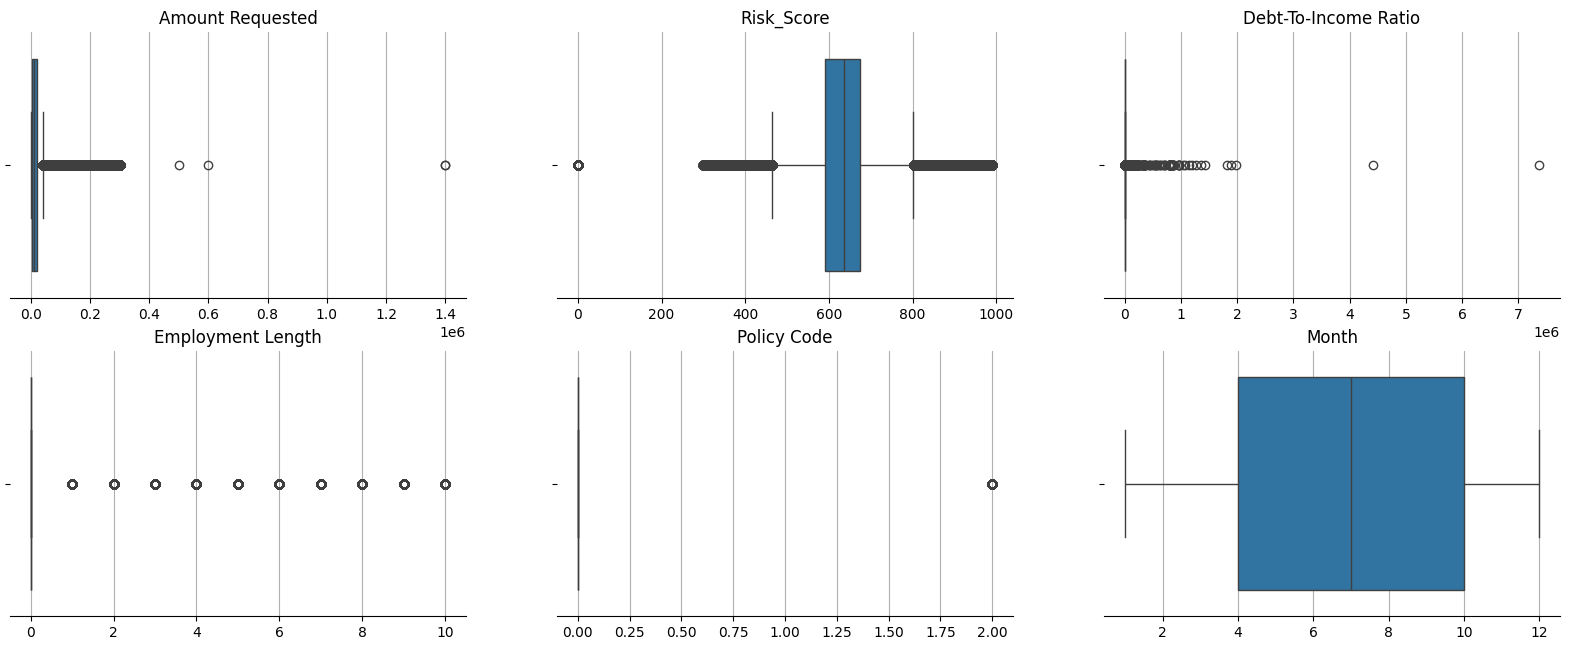

In [17]:
numeric_cols = rejected_loan_df.select_dtypes(include=np.number)

plt.figure(figsize=(20, 20))
for i in range(1, len(numeric_cols.columns)):
    plt.subplot(5, 3, i)
    outlier = sns.boxplot(x=numeric_cols.columns[i - 1], data=numeric_cols)
    outlier.xaxis.grid(True)
    outlier.set(xlabel="")
    outlier.set_title(f"{numeric_cols.columns[i-1]}")
    sns.despine(right=True, left=True)
plt.show()

In [18]:
rejected_loan_df = rejected_loan_df[rejected_loan_df["Debt-To-Income Ratio"] <= 100]
rejected_loan_df = rejected_loan_df[rejected_loan_df["Debt-To-Income Ratio"] >= 0]

From the box plots we se, that Debt-To-Income Ratio was incorrect. Also, we may see that Risk-score has outlier 0.  

The overall FICO score range or Risk score is between 300 and 850. In general, scores in the 670 to 739 range indicate a “good” credit history and most lenders will consider this score favorable. In contrast, borrowers in the 580 to 669 range may find it difficult to get financing at attractive rates. (https://www.investopedia.com/terms/f/ficoscore.asp).  
We may see, that fico scores are not all correct. Let's drop incorrect lines.

In [19]:
df_negative_risk = rejected_loan_df[rejected_loan_df["Risk_Score"] <= 0]
df_positive_risk = rejected_loan_df[rejected_loan_df["Risk_Score"] > 0]
df_missing_risk = rejected_loan_df[rejected_loan_df["Risk_Score"].isna()]

Before droping strange Risk score values, lets explore it seperatly to be certain about our decision.

In [20]:
df_negative_risk.describe()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Policy Code,Month,Year
count,27440.00,27440.00,27440.00,27320.00,27440.00,27440.00,27440.00
mean,7744.67,0.00,1.32,0.31,0.00,6.90,2011.83
std,8784.96,0.00,5.97,1.36,0.00,3.07,1.27
min,500.00,0.00,0.00,0.00,0.00,1.00,2007.00
25%,2000.00,0.00,0.00,0.00,0.00,4.00,2011.00
50%,5000.00,0.00,0.00,0.00,0.00,7.00,2012.00
75%,10000.00,0.00,0.00,0.00,0.00,9.00,2013.00
max,80000.00,0.00,100.00,10.00,0.00,12.00,2013.00


We may see, that people, who have Risk Score =0, have vary small Debt-To-Income Ratio. Looks like it is reasonable values.

In [21]:
df_positive_risk.describe()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Policy Code,Month,Year
count,2922223.00,2922223.00,2922223.00,2869924.00,2922087.00,2922223.00,2922223.00
mean,12655.51,634.15,24.34,0.54,0.00,7.18,2015.53
std,10880.56,65.63,20.87,1.93,0.09,3.71,1.98
min,0.00,300.00,0.00,0.00,0.00,1.00,2007.00
25%,4400.00,593.00,8.99,0.00,0.00,4.00,2014.00
50%,10000.00,638.00,19.92,0.00,0.00,8.00,2016.00
75%,20000.00,675.00,34.47,0.00,0.00,11.00,2017.00
max,1400000.00,990.00,100.00,10.00,2.00,12.00,2018.00


In [22]:
df_missing_risk.describe()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Policy Code,Month,Year
count,5595900.00,0.00,5595900.00,5348286.00,5595746.00,5595900.00,5595900.00
mean,12341.88,NaN,27.88,0.82,0.01,6.86,2017.05
std,10556.20,NaN,26.22,2.01,0.12,3.18,1.11
min,0.00,NaN,0.00,0.00,0.00,1.00,2007.00
25%,5000.00,NaN,9.73,0.00,0.00,4.00,2016.00
50%,10000.00,NaN,20.68,0.00,0.00,7.00,2018.00
75%,19000.00,NaN,36.46,0.00,0.00,9.00,2018.00
max,102325.00,NaN,100.00,10.00,2.00,12.00,2018.00


While I've identified ranges for the Risk_Score variable, which fall between 300 and 850, I hesitate to remove rows with NaN values or those where risk equals 0. These rows may still contain valuable information within other features. Therefore, I suggest leaving the data as it is.

Data transformation and clening is done.

In [23]:
rejected_loan_df.to_csv("final_cleaned_rejected_loan_df.csv")
